In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython.display
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from keras import regularizers

Using TensorFlow backend.


In [2]:
# key issues:
# what does accuracy mean in a regression problem? are we calculting the idea correctly?
# 

In [3]:
files = "./data/merged.csv"

# accleration file
# file_accel = "./data/accel-merge.csv"

# raw_dataset_accel = pd.read_csv(file_accel, sep=",", skipinitialspace=True)
# dataset_accel =raw_dataset_accel.copy()
# dataset_no_speed = dataset_accel
# dataset_no_speed.pop('Vehicle speed (MPH)')

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()
# dataset_accel.columns = dataset_accel.columns.str.lstrip()

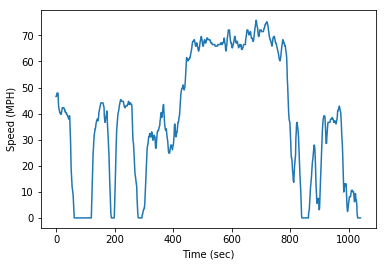

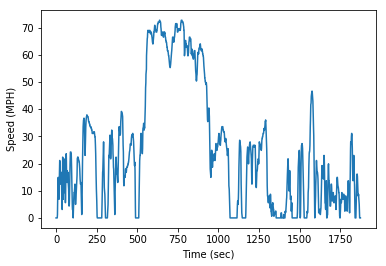

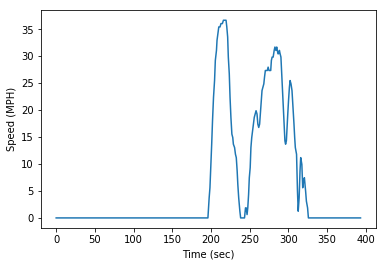

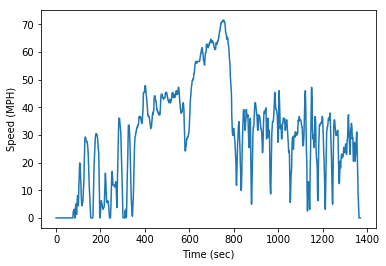

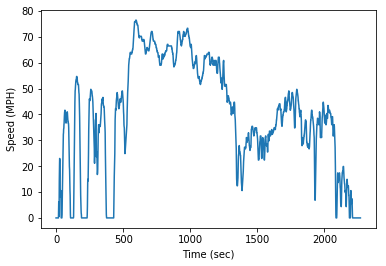

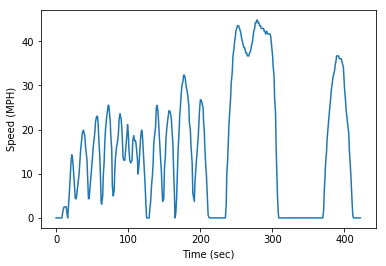

In [5]:
# adding speed and accel decreased performance
file_no_merge = ["./data/{}-Cleaned.csv".format(i) for i in range(1, 7)]

def plot_speed_time(files):
    raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
    dataset = raw_dataset.copy()
    
    time = dataset.pop("Time (sec)")
    time.tail()
    speed = dataset.pop("Vehicle speed (MPH)")
    
   
    plt.xlabel("Time (sec)")
    plt.ylabel("Speed (MPH)")
    plt.plot(time, speed)
    plt.show()
    
for file in file_no_merge:
    plot_speed_time(file)

In [4]:
# Global parameters
seed = 9

In [6]:
# Delete this in future?

#To-do: consider experimenting what happens when you remove it.
#if the maxNum = 45, there are ___1788___ obs whose MPG > 45

#a function that rounds down any value above 45 to 45.
#39 is the avg highway IFE. we then choose the number 45.
#see our doc/write up for more info?

# def set_max_ife(dataset, max_num, wanted):
#     #    count = 0
#     if not wanted: return dataset
#     copy = dataset.copy()
#     for i in range(len(dataset.index)):
#         if dataset.iloc[i, len(dataset.columns) - 1] > max_Num:
# #            count += 1
#             copy.iloc[i, len(dataset.columns) - 1] = max_Num
# #    print(count)
#     return copy
# maxed_dataset = set_max_ife(dataset, max_num, False)
# maxed_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
#Plotting a histograph to see distribution of Vehicle speed (MPH) 
#sns.distplot(maxedDataSet['Vehicle speed (MPH)']);

In [8]:
#print(list_highway_speed)
#for i in range(1,len(list_highway_speed))):
#    highway_speed_dataset = maxed_dataset[list_highway_speed[i]]


In [5]:
%%time 
#set seed here!
# dataset_accel = dataset_accel.sample(frac=1).reset_index(drop=True)
# dataset_no_speed = dataset_no_speed.sample(frac=1).reset_index(drop=True)

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
# dataset = dataset.sample(frac=1).reset_index(drop=True)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.18 ms


In [ ]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# train_stats is a pandas data frame type
train_stats = train.describe(include = 'all')
train_stats

train_stats['Vehicle speed (MPH)']

In [ ]:
train_stats['Vehicle speed (MPH)'][1] #mean

In [6]:
#we have to normalize test and validation data set by using the mean and sd from training data set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

In [7]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [MPG]')
#     plt.plot(hist['epoch'], hist['mean_absolute_error'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#     plt.ylim([0,30])
#     plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.xlim([0,epochs])
    plt.ylim([0, 8000])
    plt.legend()
    plt.show()

def getHist(test_predictions, test_labels):
    error = test_predictions - test_labels
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")
    plt.hist(error, bins = 25)
    return error

def plot_scatter(test_predictions):
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

def calculate_percent_error(test_predictions, test_labels):
    difference = abs(test_predictions - test_labels)
    error = difference / test_labels
    unprocessed_error_percentage = error * 100
    np_error = np.array(unprocessed_error_percentage)
    a = np.ma.masked_invalid(np_error)
    error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))
    print("Percentage Error: {}%".format(error_percentage))
    return (error_percentage)

def compute_acc(error_percentage):
    accuracy = 100 - error_percentage
    print("Test Accuracy: {}%".format(accuracy))

In [15]:
epochs = 250
learning_rate = 0.001
reg = 0.0001

In [16]:
# build models with different number of activation layers and number of nodes to explore
# which one has lowest testing error
def build_model_A():
    model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

def build_model_B():
    model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_model_C(reg):
    model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, use_bias=True, activity_regularizer=regularizers.l2(reg),input_shape=[len(train.keys())]),
    layers.Dense(10, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(5, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['acc', 'mean_squared_error'])
    return model

def build_model_D(reg):
    model = keras.Sequential([
    layers.Dense(330, activation=tf.nn.relu, use_bias=True, activity_regularizer=regularizers.l2(reg),input_shape=[len(train.keys())]),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(330, activation=tf.nn.relu, use_bias=True,activity_regularizer=regularizers.l2(reg)),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['acc', 'mean_squared_error'])
    return model


In [18]:
# reformatting all the code due to a "memory" bug where ipython keeps the same weights 
# as the previous model, causeing issues

In [19]:
%%time
model_A = build_model_A()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
CPU times: user 172 ms, sys: 15.6 ms, total: 188 ms
Wall time: 183 ms


In [20]:
%%time
history_object_A = model_A.fit(normed_train, train_labels, epochs=epochs, verbose=1,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
2916/2916 [==============================] - 0s 77us/sample - loss: 9157.4806 - mean_absolute_error: 55.2527 - mean_squared_error: 9157.4814 - val_loss: 7600.8136 - val_mean_absolute_error: 52.4666 - val_mean_squared_error: 7600.8140
Epoch 2/250
2916/2916 [==============================] - 0s 39us/sample - loss: 9050.1466 - mean_absolute_error: 54.6392 - mean_squared_error: 9050.1455 - val_loss: 7467.7298 - val_mean_absolute_error: 51.7652 - val_mean_squared_error: 7467.7300
Epoch 3/250
2916/2916 [==============================] - 0s 39us/sample - loss: 8880.2627 - mean_absolute_error: 53.8645 - mean_squared_error: 8880.2617 - val_loss: 7288.1948 - val_mean_absolute_error: 50.9683 - val_mean_squared_error: 7288.1943
Epoch 4/250
2916/2916 [==============================] - 0s 40us/sample - loss: 8664.3546 - mean_absolute_error: 52.9739 - mean_squared_error: 8664.3535 - val_loss: 70

Epoch 33/250
2916/2916 [==============================] - 0s 34us/sample - loss: 2630.7029 - mean_absolute_error: 27.9282 - mean_squared_error: 2630.7029 - val_loss: 1749.6993 - val_mean_absolute_error: 25.8282 - val_mean_squared_error: 1749.6992
Epoch 34/250
2916/2916 [==============================] - 0s 34us/sample - loss: 2606.9042 - mean_absolute_error: 27.7237 - mean_squared_error: 2606.9048 - val_loss: 1729.6463 - val_mean_absolute_error: 25.6158 - val_mean_squared_error: 1729.6462
Epoch 35/250
2916/2916 [==============================] - 0s 35us/sample - loss: 2584.4953 - mean_absolute_error: 27.4770 - mean_squared_error: 2584.4951 - val_loss: 1711.1150 - val_mean_absolute_error: 25.4381 - val_mean_squared_error: 1711.1150
Epoch 36/250
2916/2916 [==============================] - 0s 34us/sample - loss: 2564.3508 - mean_absolute_error: 27.3781 - mean_squared_error: 2564.3506 - val_loss: 1692.7464 - val_mean_absolute_error: 25.2212 - val_mean_squared_error: 1692.7467
Epoch 37/250

2916/2916 [==============================] - 0s 36us/sample - loss: 1863.3309 - mean_absolute_error: 20.1342 - mean_squared_error: 1863.3309 - val_loss: 1127.4126 - val_mean_absolute_error: 18.3176 - val_mean_squared_error: 1127.4126
Epoch 100/250
2916/2916 [==============================] - 0s 37us/sample - loss: 1856.5070 - mean_absolute_error: 20.1620 - mean_squared_error: 1856.5072 - val_loss: 1121.5467 - val_mean_absolute_error: 18.1505 - val_mean_squared_error: 1121.5465
Epoch 101/250
2916/2916 [==============================] - 0s 35us/sample - loss: 1851.6386 - mean_absolute_error: 19.9887 - mean_squared_error: 1851.6390 - val_loss: 1118.5414 - val_mean_absolute_error: 18.1529 - val_mean_squared_error: 1118.5414
Epoch 102/250
2916/2916 [==============================] - 0s 36us/sample - loss: 1844.5232 - mean_absolute_error: 19.9558 - mean_squared_error: 1844.5233 - val_loss: 1115.5336 - val_mean_absolute_error: 18.1752 - val_mean_squared_error: 1115.5337
Epoch 103/250
2916/291

2916/2916 [==============================] - 0s 35us/sample - loss: 1576.2064 - mean_absolute_error: 17.6521 - mean_squared_error: 1576.2067 - val_loss: 962.5967 - val_mean_absolute_error: 16.4362 - val_mean_squared_error: 962.5967
Epoch 166/250
2916/2916 [==============================] - 0s 36us/sample - loss: 1573.8178 - mean_absolute_error: 17.5379 - mean_squared_error: 1573.8179 - val_loss: 958.9483 - val_mean_absolute_error: 16.3373 - val_mean_squared_error: 958.9484
Epoch 167/250
2916/2916 [==============================] - 0s 36us/sample - loss: 1570.9361 - mean_absolute_error: 17.5200 - mean_squared_error: 1570.9360 - val_loss: 958.6199 - val_mean_absolute_error: 16.3667 - val_mean_squared_error: 958.6198
Epoch 168/250
2916/2916 [==============================] - 0s 36us/sample - loss: 1568.1013 - mean_absolute_error: 17.4515 - mean_squared_error: 1568.1016 - val_loss: 956.7672 - val_mean_absolute_error: 16.3424 - val_mean_squared_error: 956.7672
Epoch 169/250
2916/2916 [=====

2916/2916 [==============================] - 0s 40us/sample - loss: 1430.1320 - mean_absolute_error: 16.2347 - mean_squared_error: 1430.1321 - val_loss: 878.9284 - val_mean_absolute_error: 15.4338 - val_mean_squared_error: 878.9284
Epoch 232/250
2916/2916 [==============================] - 0s 39us/sample - loss: 1428.4581 - mean_absolute_error: 16.1808 - mean_squared_error: 1428.4576 - val_loss: 878.1741 - val_mean_absolute_error: 15.4291 - val_mean_squared_error: 878.1741
Epoch 233/250
2916/2916 [==============================] - 0s 40us/sample - loss: 1425.2517 - mean_absolute_error: 16.2618 - mean_squared_error: 1425.2516 - val_loss: 875.7885 - val_mean_absolute_error: 15.3490 - val_mean_squared_error: 875.7885
Epoch 234/250
2916/2916 [==============================] - 0s 37us/sample - loss: 1425.1257 - mean_absolute_error: 16.1408 - mean_squared_error: 1425.1257 - val_loss: 872.1226 - val_mean_absolute_error: 15.2413 - val_mean_squared_error: 872.1227
Epoch 235/250
2916/2916 [=====

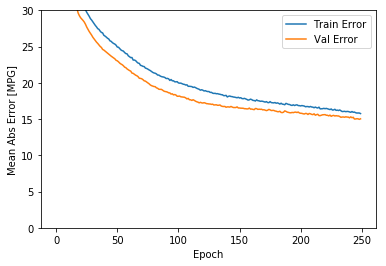

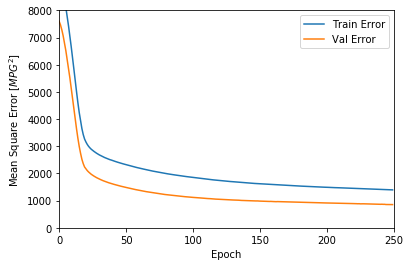

In [21]:
plot_history(history_object_A)

Percentage Error: 35.5144661928798%
Test Accuracy: 64.48553380712019%


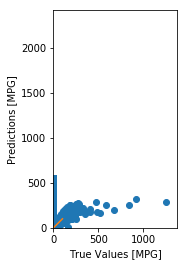

In [27]:
test_predictions_A = model_A.predict(normed_test).flatten()
error_A = getHist(test_predictions_A, test_labels)
plot_scatter(test_predictions_A)
p_err_A = calculate_percent_error(test_predictions_A, test_labels)
compute_acc(p_err_A)

In [78]:
model_B = build_model_B()

In [79]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=epochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Epoch 1/250
 - 0s - loss: 9231.9358 - mean_absolute_error: 56.5507 - mean_squared_error: 9231.9346 - val_loss: 7615.9142 - val_mean_absolute_error: 53.5218 - val_mean_squared_error: 7615.9141
Epoch 2/250
 - 0s - loss: 9019.9518 - mean_absolute_error: 55.5114 - mean_squared_error: 9019.9502 - val_loss: 7417.7372 - val_mean_absolute_error: 52.5365 - val_mean_squared_error: 7417.7378
Epoch 3/250
 - 0s - loss: 8781.2190 - mean_absolute_error: 54.4135 - mean_squared_error: 8781.2188 - val_loss: 7169.4679 - val_mean_absolute_error: 51.3694 - val_mean_squared_error: 7169.4678
Epoch 4/250
 - 0s - loss: 8474.3938 - mean_absolute_error: 53.0770 - mean_squared_error: 8474.3936 - val_loss: 6850.8511 - val_mean_absolute_error: 49.9420 - val_mean_squared_error: 6850.8516
Epoch 5/250
 - 0s - loss: 8099.3510 - mean_absolute_error: 51.4318 - mean_squared_error: 8099.3491 - val_loss: 6468.1917 - val_mean_absolute_error: 48.1746 - val_mean_squared_error: 646

Epoch 44/250
 - 0s - loss: 1811.2849 - mean_absolute_error: 19.7101 - mean_squared_error: 1811.2852 - val_loss: 1084.6367 - val_mean_absolute_error: 17.8671 - val_mean_squared_error: 1084.6367
Epoch 45/250
 - 0s - loss: 1797.6744 - mean_absolute_error: 19.5692 - mean_squared_error: 1797.6749 - val_loss: 1077.1629 - val_mean_absolute_error: 17.8017 - val_mean_squared_error: 1077.1628
Epoch 46/250
 - 0s - loss: 1784.7453 - mean_absolute_error: 19.3933 - mean_squared_error: 1784.7454 - val_loss: 1070.7673 - val_mean_absolute_error: 17.7739 - val_mean_squared_error: 1070.7673
Epoch 47/250
 - 0s - loss: 1771.6567 - mean_absolute_error: 19.3625 - mean_squared_error: 1771.6565 - val_loss: 1062.9725 - val_mean_absolute_error: 17.6404 - val_mean_squared_error: 1062.9725
Epoch 48/250
 - 0s - loss: 1760.1076 - mean_absolute_error: 19.2803 - mean_squared_error: 1760.1077 - val_loss: 1055.2404 - val_mean_absolute_error: 17.4640 - val_mean_squared_error: 1055.2405
Epoch 49/250
 - 0s - loss: 1750.923

Epoch 87/250
 - 0s - loss: 1498.6217 - mean_absolute_error: 16.5034 - mean_squared_error: 1498.6215 - val_loss: 932.4551 - val_mean_absolute_error: 15.8074 - val_mean_squared_error: 932.4551
Epoch 88/250
 - 0s - loss: 1496.0724 - mean_absolute_error: 16.4340 - mean_squared_error: 1496.0720 - val_loss: 927.6082 - val_mean_absolute_error: 15.6629 - val_mean_squared_error: 927.6083
Epoch 89/250
 - 0s - loss: 1489.6656 - mean_absolute_error: 16.4570 - mean_squared_error: 1489.6653 - val_loss: 928.8848 - val_mean_absolute_error: 15.7971 - val_mean_squared_error: 928.8848
Epoch 90/250
 - 0s - loss: 1485.1712 - mean_absolute_error: 16.3934 - mean_squared_error: 1485.1713 - val_loss: 924.5882 - val_mean_absolute_error: 15.6559 - val_mean_squared_error: 924.5881
Epoch 91/250
 - 0s - loss: 1481.9449 - mean_absolute_error: 16.2791 - mean_squared_error: 1481.9449 - val_loss: 923.9806 - val_mean_absolute_error: 15.6601 - val_mean_squared_error: 923.9805
Epoch 92/250
 - 0s - loss: 1477.0747 - mean_a

Epoch 130/250
 - 0s - loss: 1351.5088 - mean_absolute_error: 14.6927 - mean_squared_error: 1351.5088 - val_loss: 858.3626 - val_mean_absolute_error: 14.5071 - val_mean_squared_error: 858.3627
Epoch 131/250
 - 0s - loss: 1347.2821 - mean_absolute_error: 14.7757 - mean_squared_error: 1347.2821 - val_loss: 851.6878 - val_mean_absolute_error: 14.1640 - val_mean_squared_error: 851.6878
Epoch 132/250
 - 0s - loss: 1345.2237 - mean_absolute_error: 14.6129 - mean_squared_error: 1345.2236 - val_loss: 858.9472 - val_mean_absolute_error: 14.5859 - val_mean_squared_error: 858.9471
Epoch 133/250
 - 0s - loss: 1340.7479 - mean_absolute_error: 14.8086 - mean_squared_error: 1340.7479 - val_loss: 852.1081 - val_mean_absolute_error: 14.3470 - val_mean_squared_error: 852.1080
Epoch 134/250
 - 0s - loss: 1340.3849 - mean_absolute_error: 14.6623 - mean_squared_error: 1340.3853 - val_loss: 853.0068 - val_mean_absolute_error: 14.4133 - val_mean_squared_error: 853.0068
Epoch 135/250
 - 0s - loss: 1337.6458 - 

Epoch 173/250
 - 0s - loss: 1254.6282 - mean_absolute_error: 13.8331 - mean_squared_error: 1254.6283 - val_loss: 804.4951 - val_mean_absolute_error: 13.5863 - val_mean_squared_error: 804.4951
Epoch 174/250
 - 0s - loss: 1252.3703 - mean_absolute_error: 13.7935 - mean_squared_error: 1252.3701 - val_loss: 801.5836 - val_mean_absolute_error: 13.4998 - val_mean_squared_error: 801.5835
Epoch 175/250
 - 0s - loss: 1250.6087 - mean_absolute_error: 13.7610 - mean_squared_error: 1250.6085 - val_loss: 802.6445 - val_mean_absolute_error: 13.5942 - val_mean_squared_error: 802.6445
Epoch 176/250
 - 0s - loss: 1249.4244 - mean_absolute_error: 13.7762 - mean_squared_error: 1249.4244 - val_loss: 802.0249 - val_mean_absolute_error: 13.5577 - val_mean_squared_error: 802.0250
Epoch 177/250
 - 0s - loss: 1247.8868 - mean_absolute_error: 13.7031 - mean_squared_error: 1247.8867 - val_loss: 798.9974 - val_mean_absolute_error: 13.4365 - val_mean_squared_error: 798.9974
Epoch 178/250
 - 0s - loss: 1245.9292 - 

Epoch 216/250
 - 0s - loss: 1181.2878 - mean_absolute_error: 13.2241 - mean_squared_error: 1181.2878 - val_loss: 773.0373 - val_mean_absolute_error: 13.3833 - val_mean_squared_error: 773.0372
Epoch 217/250
 - 0s - loss: 1178.5949 - mean_absolute_error: 13.3428 - mean_squared_error: 1178.5947 - val_loss: 766.5875 - val_mean_absolute_error: 13.1383 - val_mean_squared_error: 766.5875
Epoch 218/250
 - 0s - loss: 1177.8352 - mean_absolute_error: 13.1917 - mean_squared_error: 1177.8351 - val_loss: 772.4916 - val_mean_absolute_error: 13.4330 - val_mean_squared_error: 772.4916
Epoch 219/250
 - 0s - loss: 1176.7027 - mean_absolute_error: 13.2236 - mean_squared_error: 1176.7026 - val_loss: 769.2482 - val_mean_absolute_error: 13.3096 - val_mean_squared_error: 769.2481
Epoch 220/250
 - 0s - loss: 1173.7777 - mean_absolute_error: 13.2736 - mean_squared_error: 1173.7776 - val_loss: 768.6855 - val_mean_absolute_error: 13.2990 - val_mean_squared_error: 768.6855
Epoch 221/250
 - 0s - loss: 1173.7712 - 

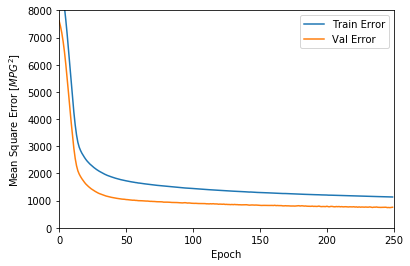

In [80]:
plot_history(history_object_B)

Percentage Error: 42.86258095805907%
Test Accuracy: 57.13741904194093%


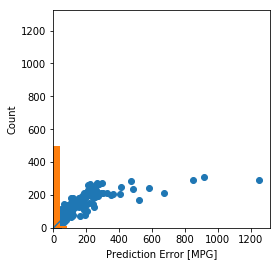

In [81]:
test_predictions_B = model_B.predict(normed_test).flatten()
plot_scatter(test_predictions_B)
error_B = getHist(test_predictions_B, test_labels)
p_err_B = calculate_percent_error(test_predictions_B, test_labels)
compute_acc(p_err_B)

In [88]:
model_C = build_model_C(reg=0.1)

In [89]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_C = model_C.fit(normed_train, train_labels, epochs=epochs, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Epoch 1/250
 - 0s - loss: 9118.8664 - acc: 0.1241 - mean_squared_error: 9117.6143 - val_loss: 7454.6867 - val_acc: 0.0051 - val_mean_squared_error: 7452.6694
Epoch 2/250
 - 0s - loss: 8668.6825 - acc: 0.0017 - mean_squared_error: 8664.6445 - val_loss: 6837.2022 - val_acc: 0.0000e+00 - val_mean_squared_error: 6830.2637
Epoch 3/250
 - 0s - loss: 7726.9177 - acc: 0.0000e+00 - mean_squared_error: 7714.0776 - val_loss: 5659.9840 - val_acc: 0.0000e+00 - val_mean_squared_error: 5639.1528
Epoch 4/250
 - 0s - loss: 6123.2587 - acc: 0.0000e+00 - mean_squared_error: 6086.3628 - val_loss: 3939.0032 - val_acc: 0.0000e+00 - val_mean_squared_error: 3880.4890
Epoch 5/250
 - 0s - loss: 4429.5603 - acc: 0.0000e+00 - mean_squared_error: 4340.3696 - val_loss: 2754.6652 - val_acc: 0.0000e+00 - val_mean_squared_error: 2635.6489
Epoch 6/250
 - 0s - loss: 3429.9854 - acc: 0.0000e+00 - mean_squared_error: 3272.8960 - val_loss: 2291.1431 - val_acc: 0.0000e+00 - val

Epoch 52/250
 - 0s - loss: 1251.1373 - acc: 0.0000e+00 - mean_squared_error: 1152.1493 - val_loss: 873.6178 - val_acc: 0.0000e+00 - val_mean_squared_error: 781.2576
Epoch 53/250
 - 0s - loss: 1241.0322 - acc: 0.0000e+00 - mean_squared_error: 1144.4939 - val_loss: 896.3982 - val_acc: 0.0000e+00 - val_mean_squared_error: 796.7332
Epoch 54/250
 - 0s - loss: 1230.2524 - acc: 0.0000e+00 - mean_squared_error: 1132.5474 - val_loss: 870.7970 - val_acc: 0.0000e+00 - val_mean_squared_error: 775.2079
Epoch 55/250
 - 0s - loss: 1221.8982 - acc: 0.0000e+00 - mean_squared_error: 1125.2120 - val_loss: 846.0823 - val_acc: 0.0000e+00 - val_mean_squared_error: 758.9790
Epoch 56/250
 - 0s - loss: 1211.7228 - acc: 0.0000e+00 - mean_squared_error: 1116.7996 - val_loss: 841.2596 - val_acc: 0.0000e+00 - val_mean_squared_error: 752.4902
Epoch 57/250
 - 0s - loss: 1201.7224 - acc: 0.0000e+00 - mean_squared_error: 1107.7323 - val_loss: 832.1766 - val_acc: 0.0000e+00 - val_mean_squared_error: 747.6813
Epoch 58/2

Epoch 102/250
 - 0s - loss: 835.8189 - acc: 0.0000e+00 - mean_squared_error: 771.8549 - val_loss: 618.7717 - val_acc: 0.0000e+00 - val_mean_squared_error: 556.7822
Epoch 103/250
 - 0s - loss: 827.7567 - acc: 0.0000e+00 - mean_squared_error: 764.2380 - val_loss: 604.4998 - val_acc: 0.0000e+00 - val_mean_squared_error: 544.6086
Epoch 104/250
 - 0s - loss: 823.6815 - acc: 0.0000e+00 - mean_squared_error: 760.6199 - val_loss: 600.1321 - val_acc: 0.0000e+00 - val_mean_squared_error: 541.9099
Epoch 105/250
 - 0s - loss: 816.5427 - acc: 0.0000e+00 - mean_squared_error: 754.4490 - val_loss: 645.1448 - val_acc: 0.0000e+00 - val_mean_squared_error: 581.2900
Epoch 106/250
 - 0s - loss: 810.6806 - acc: 0.0000e+00 - mean_squared_error: 748.4307 - val_loss: 591.1926 - val_acc: 0.0000e+00 - val_mean_squared_error: 533.4626
Epoch 107/250
 - 0s - loss: 794.3651 - acc: 0.0000e+00 - mean_squared_error: 732.4890 - val_loss: 591.8366 - val_acc: 0.0000e+00 - val_mean_squared_error: 533.9583
Epoch 108/250
 -

Epoch 152/250
 - 0s - loss: 542.2931 - acc: 0.0000e+00 - mean_squared_error: 495.6400 - val_loss: 365.6360 - val_acc: 0.0000e+00 - val_mean_squared_error: 324.6837
Epoch 153/250
 - 0s - loss: 540.5186 - acc: 0.0000e+00 - mean_squared_error: 494.4849 - val_loss: 360.5478 - val_acc: 0.0000e+00 - val_mean_squared_error: 319.9079
Epoch 154/250
 - 0s - loss: 536.6413 - acc: 0.0000e+00 - mean_squared_error: 490.9402 - val_loss: 406.2536 - val_acc: 0.0000e+00 - val_mean_squared_error: 359.6676
Epoch 155/250
 - 0s - loss: 534.3925 - acc: 0.0000e+00 - mean_squared_error: 488.5016 - val_loss: 368.2818 - val_acc: 0.0000e+00 - val_mean_squared_error: 324.6142
Epoch 156/250
 - 0s - loss: 522.4795 - acc: 0.0000e+00 - mean_squared_error: 476.8811 - val_loss: 351.0194 - val_acc: 0.0000e+00 - val_mean_squared_error: 311.6657
Epoch 157/250
 - 0s - loss: 519.9062 - acc: 0.0000e+00 - mean_squared_error: 474.8253 - val_loss: 366.0898 - val_acc: 0.0000e+00 - val_mean_squared_error: 322.4261
Epoch 158/250
 -

Epoch 202/250
 - 0s - loss: 341.1523 - acc: 0.0000e+00 - mean_squared_error: 304.2136 - val_loss: 260.2684 - val_acc: 0.0000e+00 - val_mean_squared_error: 225.8630
Epoch 203/250
 - 0s - loss: 344.7260 - acc: 0.0000e+00 - mean_squared_error: 308.1287 - val_loss: 307.1358 - val_acc: 0.0000e+00 - val_mean_squared_error: 270.9751
Epoch 204/250
 - 0s - loss: 340.7605 - acc: 0.0000e+00 - mean_squared_error: 304.3263 - val_loss: 293.0562 - val_acc: 0.0000e+00 - val_mean_squared_error: 257.0410
Epoch 205/250
 - 0s - loss: 335.4640 - acc: 3.4294e-04 - mean_squared_error: 298.8365 - val_loss: 265.8199 - val_acc: 0.0000e+00 - val_mean_squared_error: 232.1822
Epoch 206/250
 - 0s - loss: 334.0312 - acc: 3.4294e-04 - mean_squared_error: 297.9449 - val_loss: 254.9291 - val_acc: 0.0000e+00 - val_mean_squared_error: 221.6081
Epoch 207/250
 - 0s - loss: 325.9066 - acc: 3.4294e-04 - mean_squared_error: 289.6077 - val_loss: 258.1302 - val_acc: 0.0000e+00 - val_mean_squared_error: 225.3450
Epoch 208/250
 -

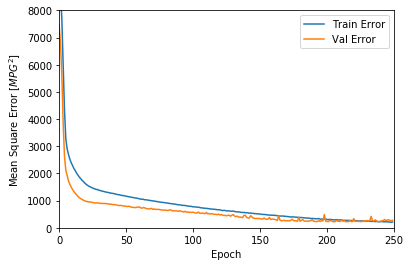

In [90]:
plot_history(history_object_C)

Percentage Error: 25.085029867874706%
Test Accuracy: 74.91497013212529%


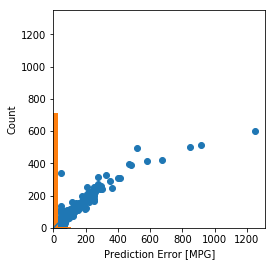

In [91]:
test_predictions_C = model_C.predict(normed_test).flatten()
plot_scatter(test_predictions_C)
errorC = getHist(test_predictions_C, test_labels)
p_err_C = calculate_percent_error(test_predictions_C, test_labels)
compute_acc(p_err_C)

In [17]:
model_D = build_model_D(reg=0.01)

In [ ]:
%%time
history_object_D = model_D.fit(normed_train, train_labels, epochs=130, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 2916 samples, validate on 972 samples
Epoch 1/130
 - 1s - loss: 3173.7033 - acc: 0.0055 - mean_squared_error: 3111.4675 - val_loss: 4249.9695 - val_acc: 0.0000e+00 - val_mean_squared_error: 4233.7446
Epoch 2/130
 - 1s - loss: 2345.0768 - acc: 0.0014 - mean_squared_error: 2286.4294 - val_loss: 1982.3733 - val_acc: 0.0000e+00 - val_mean_squared_error: 1937.6781
Epoch 3/130
 - 0s - loss: 2153.5534 - acc: 0.0045 - mean_squared_error: 2096.6125 - val_loss: 2753.1736 - val_acc: 0.1214 - val_mean_squared_error: 2730.3044
Epoch 4/130
 - 1s - loss: 1997.2467 - acc: 0.0360 - mean_squared_error: 1945.3921 - val_loss: 2795.2178 - val_acc: 0.0566 - val_mean_squared_error: 2773.1118
Epoch 5/130
 - 0s - loss: 1775.0285 - acc: 0.0350 - mean_squared_error: 1725.5098 - val_loss: 1857.0829 - val_acc: 0.1039 - val_mean_squared_error: 1823.4944
Epoch 6/130
 - 1s - loss: 1614.0215 - acc: 0.0442 - mean_squared_error: 1567.0458 - val_loss: 7466.6886 - val_acc: 0.1049 - val_mean_squared_error: 7319.69

Epoch 53/130
 - 0s - loss: 454.5933 - acc: 0.0995 - mean_squared_error: 429.5149 - val_loss: 1170.2675 - val_acc: 0.1265 - val_mean_squared_error: 1156.1492
Epoch 54/130
 - 0s - loss: 265.5559 - acc: 0.1022 - mean_squared_error: 241.8804 - val_loss: 653.0854 - val_acc: 0.0134 - val_mean_squared_error: 633.2832
Epoch 55/130
 - 0s - loss: 352.6562 - acc: 0.0806 - mean_squared_error: 329.1053 - val_loss: 680.9468 - val_acc: 0.1019 - val_mean_squared_error: 659.9801
Epoch 56/130
 - 0s - loss: 356.1384 - acc: 0.1060 - mean_squared_error: 332.9431 - val_loss: 727.3271 - val_acc: 0.0123 - val_mean_squared_error: 708.6876
Epoch 57/130
 - 0s - loss: 330.6017 - acc: 0.0837 - mean_squared_error: 307.3954 - val_loss: 829.0155 - val_acc: 0.0309 - val_mean_squared_error: 803.8963
Epoch 58/130
 - 1s - loss: 347.5579 - acc: 0.0995 - mean_squared_error: 322.7390 - val_loss: 1099.8769 - val_acc: 0.1091 - val_mean_squared_error: 1085.4937
Epoch 59/130
 - 0s - loss: 243.0069 - acc: 0.0854 - mean_squared_e

In [ ]:
plot_history(history_object_D)

In [ ]:
test_predictions_D = model_D.predict(normed_test).flatten()
plot_scatter(test_predictions_D)
error_D = getHist(test_predictions_D, test_labels)
p_err_D = calculate_percent_error(test_predictions_D, test_labels)
compute_acc(p_err_D)

In [24]:
# probably don't need anything beyond this cell...delete?

In [ ]:
# def print_weights(model):
#     print(model.get_weights())
# #     weight_df = pd.DataFrame((model.get_weights()))
# #    print(weight_df.shape)
# #    print(weight_df)
    
# print_weights(model_A)
# print("---------------------")
# # print_weights(model_B)
# # print("---------------------")
# # print_weights(model_C)

In [ ]:
# implementing linear regression 
lm = LinearRegression()

# the data was editting so that the max IFO is 45
model = lm.fit(normed_train, train_labels)

predictions = lm.predict(normed_test) # this is a np array, be careful
print(len(predictions))
print(type(predictions))
# print(type())
print(len(test_labels.values))

In [ ]:
# Linear Regression plot
# lots of weird looking outliers at true values = 0, 45

def plot_scatter(y, y_hat):
    
    plt.figure
    plt.scatter(y, y_hat)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

In [ ]:
# prediction no cap
plot_scatter(test_labels, predictions)

In [ ]:
# Accuracy of linear regression
def calculate_percent_error_lr(test_predictions, test_labels):
    difference = abs(test_predictions - test_labels)
    error = difference / test_labels
    unprocessed_error_percentage = error * 100
    
#     np_error = np.array(unprocessed_error_percentage)
#     a = np.ma.masked_invalid(np_error)
#     error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))

    print(error_percentage)
    return (error_percentage)
np_test_labels = test_labels.values
percent_error_lr = calculate_percent_error_lr(predictions, np_test_labels)
compute_acc(percent_error_lr)
print(len(predictions))
print(len(test_labels))